# CSE 541 HW 3
Evan Komp

In [3]:
import numpy as np
from mnist import MNIST
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.linear_model

import matplotlib.pyplot as plt

***
## 1

Expected regret of tau greedy

For $n$ total timesteps nature reveals $(C_t)_{t=1}^n\in \mathcal{C}$ contexts. We take an action $A_t \in [k]$ and observe reward $X_t$ based on context and action taken. Define $\mu(C_t, A_t) = \mathbb{E}(X_t) = \int x P(x|A_t,C_t)$. For policies $\phi\in\Phi: \mathcal{C}\rightarrow k$ define $\mu(\phi)=\int\mu(C,\phi(C)d\xi(C))$.

The regret of any algorithm:

$$R_n = n\cdot sup_\phi \mu(\phi) - \mathbb{E}\left[\sum_t^n X_t\right]$$

The tau greedy algorithm:

1. For $m$ rounds, select $A_t$ uniformly at random from $[k]$. Define $\hat{\mu}(\phi) = \frac{k}{m}\sum_{t=1}^m \mathbb{1}\{A_t=\phi(C_t)\}X_t$. $\hat{X}_{ti}=k\mathbb{1}\{A_t=\phi(C_t)\}X_t$
2. For $t=m,...,n$ select $A_t = [\textrm{argmax}_\phi \hat{\mu}(\phi)](C_t)$


To bound the expected regret, we first need to bound regret with high probability. We can do this by showing that our policy value estimator $\hat{\mu}$ is close to the true policy value $\mu$ by some bound. If the estimator is constructed properly, we can use bernstein's innequality to bound this difference. 

First let us prove that our estimator is unbiased:

1. $$\mathbb{E}[\hat{\mu}(\phi)] = \frac{1}{m}\sum^m_{t=1}\mathbb{E}[\hat{X}_{t\phi(C_t)}]= \frac{1}{m}\sum^m_{t=1}\mathbb{E}_{C_t\sim\mathcal{C}}[\mathbb{E}[\hat{X}_{t\phi(C_t)}|C_t]]$$

2. $$\mathbb{E}[\hat{X}_{t\phi(C_t)}|C_t] = \mathbb{E}[k\mathbb{1}\{A_t=\phi(C_t)\}X_t|C_t]$$

Noting that the probability of any arm is $1/k$ since we sampled uniformly, and the indicator is only on for one of those actions:

$$=\sum_{A_t'\in [k]}\frac{1}{k}\mathbb{E}[k\mathbb{1}\{A_t=\phi(C_t)\}X_t|C_t, A_t = A_t'] = \sum_{A_t'\in [k]}\mathbb{1}\{A_t'=\phi(C_t)\}\mu(C_t,A_t') = \mu(C_t,A_t)$$

Plugging this back into (1):

$$\frac{1}{m}\sum^m_{t=1}\mathbb{E}_{C_t\sim\mathcal{C}}[\mu(C_t,A_t)] = \mu(\phi)$$

Unbiased!

And the variance:

$$\mathbb{E}[(\hat{\mu}(\phi)-\mathbb{E}[\hat{\mu}(\phi)])^2] = \mathbb{E}[(\hat{\mu}(\phi)-\mu(\phi))^2]$$

Noting that $X_t, \hat{X_{ti}}\in [0,1]$

$$= \frac{1}{m^2}\sum_{t=1}^m\mathbb{E}_{C_t\sim\mathcal{C}}\left[\mathbb{E}\left[(\hat{X}_{t\phi(C_t)}-X_t)^2|C_t\right]\right]$$

$$\le \frac{1}{m^2}\sum_{t=1}^m\mathbb{E}_{C_t\sim\mathcal{C}}\left[\mathbb{E}\left[\hat{X}_{t\phi(C_t)}^2|C_t\right]\right] = \frac{1}{m^2}\sum_{t=1}^m\mathbb{E}_{C_t\sim\mathcal{C}}\left[\mathbb{E}\left[(k\mathbb{1}\{A_t=\phi(C_t)\}X_t)^2|C_t\right]\right]$$

Again, since $X_t\le 1$:

$$\le \frac{1}{m^2}\sum_{t=1}^m\mathbb{E}_{C_t\sim\mathcal{C}}\left[]\right]$$

***
## 2
Load and contextualize the data

In [61]:
## hyperparameters
n = 10
d = 20

In [62]:
def randargmax(b,**kw):
    return np.argmax(np.random.random(b.shape) * (b==b.max()), **kw)

In [63]:
mndata = MNIST('../../python-mnist/data')
# mndata.select_emnist('balanced')
images, labels = mndata.load_training()

In [64]:
images = np.array(images)
labels = np.array(labels)

In [65]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [66]:
# this is not balanced as it was supposed to be .... balance it
num_each = 5000
C = []
y = []
for digit in np.unique(labels):
    mask = np.argwhere(labels == digit)
    C_select = images[mask.reshape(-1)]
    y_select = labels[mask]
    ind = np.random.choice(len(mask), size=num_each, replace=False)
    C.append(C_select[ind])
    y.append(y_select[ind])
C = np.concatenate(C)
y = np.concatenate(y)

# shuffle the results
ind = np.random.choice(len(y), size=len(y), replace=False)
C = C[ind]
y = y[ind]

In [67]:
np.save('C.npy', C)
np.save('y.npy', y)

In [68]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [11]:
#normalize images
C = C/256

In [12]:
# PCA to d and scale
pca = sklearn.decomposition.PCA(d)
C = pca.fit_transform(C)
# scaler = sklearn.preprocessing.MinMaxScaler()
# C = scaler.fit_transform(C)
# scaler = sklearn.preprocessing.Normalizer()
# C = scaler.fit_transform(C)
C = C / np.linalg.norm(C, axis=1).reshape(-1,1)

In [13]:
C.shape

(50000, 20)

## Model classes

In [49]:
class Agent:
    
    def __init__(self, C, y, T, n=n, gamma=1.0, log_rate=10):
        self.C = C
        self.y = y
        self.T = T
        self.n = n
        self.gamma = gamma
        self.log_rate = log_rate
        self.R_log = []
        self.R = 0.0
        self.t = 0
        self.d = C.shape[1]
        self.phi_d = int(self.d*n)
        
        self.V = np.eye(self.phi_d) * gamma
        self.V_inv = np.linalg.inv(self.V)
        self.log_det_V0 = self.phi_d*np.log(self.gamma)
        self.log_det_V = self.phi_d*np.log(self.gamma)
        self.S = np.zeros((self.phi_d,1))
        
        self.L = max(np.linalg.norm(C, axis=1))
        
        self.startup()
        return
    
    @property
    def theta(self):
        return self.V_inv @ self.S
    
    def startup(self):
        raise NotImplemented()
        
    def phi(self, ind, a):
        """Featurize the action played and the context given.
        
        Parameters
        ----------
        ind : index of context raised
        a : index of action played
        """
        c = self.C[ind]
        out = np.zeros((self.n, c.size))
        out[a] = c
        assert out.size == self.phi_d
        return out.flatten()
    
    def r(self, ind, a):
        """Reward
        
        Parameters
        ----------
        ind : index of context raised
        a : index of action played
        """
        return int(self.y[ind] == a)
    
    def pull(self, ind, a):
        """Commit an agent action. Updates regret.
        
        The problem statement was fixed to have optimal policy always give reward of 1.
        So for a play is just 1 - reward
        
        Parameters
        ----------
        ind : index of context raised
        a : index of action played
        """
        r = self.r(ind, a)
        self.R += 1.0 - r
        if r != 1:
            print('!!!regret incurred!!!')
            
        self.update(ind, a, r)
        # print(f'Pulled arm {a} for context {ind} and recieved reward {r}.')
        if self.t % self.log_rate == 0:
            self.R_log.append((self.t, self.R))
        self.t += 1
        return r
    
    def run(self):
        """Run the algorithm until T."""
        regret = []
        while self.t < self.T:
            ind_t = self.t
            at = self.pick(ind_t)
            r = self.pull(ind_t, at)
            regret.append(1-r)
        return regret
    
    def pick(self, ind):
        """Pick arm based on context vector
        
        parameters
        ind - index of the context that was raised
        """
        raise NotImplemented()
        
    def update(self, ind, a, r):
        phis = self.phi(ind,a).reshape((-1,1))
        self.S += r * phis
        self.V += phis @ (phis.T)
        self.log_det_V = self.log_det_V + np.log(1 + phis.T @ self.V_inv @ phis)
        self.V_inv = self.V_inv - (self.V_inv @ phis @ phis.T @ self.V_inv)/(1 + phis.T @ self.V_inv @ phis)
        return
            

## ETC

In [ ]:
class ETC(Agent):
    
    def __init__(self, C, y, T, tau, n=n, log_rate=10):
        self.tau = tau
        super().__init__(C, y, T, n=n, log_rate=log_rate)
        return
    
    def startup(self):
        
        for i in range(self.tau):
            
            ind_t = np.random.choice(len(self.y))
            at = np.random.choice(self.n)
            r = self.pull(ind_t, at)
        self.theta_lock = np.array(self.theta)
        return
            
    def pick(self, ind):
        phis = [self.phi(ind, a) for a in range(self.n)]
        r_hats = [self.theta_lock.reshape(1,-1) @ phi.reshape(-1,1) for phi in phis]
        return np.argmax(r_hats)

In [ ]:
etc = ETC(C,y, 20000, 1000)

In [ ]:
etc.run()

In [ ]:
plt.plot(*np.array(etc.R_log).T)

In [ ]:
class ETC_bias(Agent):
    
    def __init__(self, C, y, T, tau, n=n, log_rate=10):
        self.tau = tau
        super().__init__(C, y, T, n=n, log_rate=log_rate)
        return
    
    def startup(self):
        Cs = []
        ys = []
        for i in range(self.tau):
            ind_t = np.random.choice(len(self.y))
            at = np.random.choice(self.n)
            r = self.pull(ind_t, at)
            if r == 1:
                Cs.append(self.C[ind_t])
                ys.append(self.y[ind_t])
        Cs = np.array(Cs)
        ys = np.array(ys).reshape(-1,1)
        
        model = sklearn.linear_model.SGDClassifier()
        model.fit(Cs, ys)
        self.model = model
        return
            
    def pick(self, ind):
        at = self.model.predict(self.C[ind].reshape(1,-1))
        return int(at)

In [ ]:
etc_bias = ETC_bias(C,y, 20000, 1000)

In [ ]:
etc_bias.run()

In [ ]:
plt.plot(*np.array(etc_bias.R_log).T)

In [ ]:
class FTL(ETC):
    
    def pick(self, ind):
        phis = [self.phi(ind, a) for a in range(self.n)]
        r_hats = np.array([self.theta.reshape(1,-1) @ phi.reshape(-1,1) for phi in phis])
        return randargmax(r_hats)
    

In [ ]:
ftl = FTL(C,y, 20000, 1000)

In [ ]:
ftl.run()

In [ ]:
np.linalg.norm(ftl.theta)

In [ ]:
plt.plot(*np.array(ftl.R_log).T)

## UCB

In [50]:
class UCB(Agent):
    
    def __init__(self, C, y, T, beta_type='const', max_bound=False, n=n, gamma=1.0, log_rate=10):
        self.max_bound = max_bound
        self.beta_type = beta_type
        self.beta_log = []
        self.elip_log = []
        super().__init__(C, y, T, n=n, log_rate=log_rate, gamma=gamma)
        return
    
    
    def startup(self):
        self.del_ = 1/self.T
        return
    
    @property
    def beta(self):
        if self.beta_type == 'det':
            return (
                np.sqrt(self.gamma) + np.sqrt(
                    2*np.log(1/self.del_) + self.log_det_V - self.log_det_V0)
                )
        elif self.beta_type == 'const':
            return (
                np.sqrt(self.gamma) + np.sqrt(
                    2*np.log(1/self.del_)
                )
            )
        elif self.beta_type == 'L':
            d = self.phi_d
            return (
                np.sqrt(self.gamma) + np.sqrt(
                    2*np.log(1/self.del_) + d*np.log((d*self.gamma + self.T*self.L**2)/(d*self.L)))
            )
    
    def pick(self, ind):
        print(f'Context {ind} revealed with true label {self.y[ind]}')
        beta = self.beta
        self.beta_log.append(beta)
        theta = self.theta
        phis = np.array([self.phi(ind, a) for a in range(self.n)])
        r_hats = phis @ theta
        elip = []
        for phi in phis:
            elip.append(np.sqrt(phi.reshape(1,-1) @ self.V_inv @ phi.reshape(-1,1)))
        elip = np.array(elip).reshape(-1,1)
        self.elip_log.append(elip)
        bound = np.sqrt(beta) * elip
        if self.max_bound:
            bound = bound/max(bound)
            
        print('det V: ', np.linalg.det(self.V))
        print('Beta: ', beta)
        print('Predicted reward:confidence')
        print(np.concatenate([r_hats, bound], axis=1))
        a = randargmax(r_hats + bound)
        print(f'Chose arm {a}')
        return a

In [51]:
ucb = UCB(C,y, 50000, gamma = 1, beta_type='det', max_bound=False)

In [52]:
regret = ucb.run()

Context 0 revealed with true label [7]
det V:  1.0
Beta:  5.291932052578694
Predicted reward:confidence
[[0.         2.30041997]
 [0.         2.30041997]
 [0.         2.30041997]
 [0.         2.30041997]
 [0.         2.30041997]
 [0.         2.30041997]
 [0.         2.30041997]
 [0.         2.30041997]
 [0.         2.30041997]
 [0.         2.30041997]]
Chose arm 3
!!!regret incurred!!!
Context 1 revealed with true label [7]
det V:  1.9999999999999951
Beta:  [[5.3719364]]
Predicted reward:confidence
[[0.         2.31774382]
 [0.         2.31774382]
 [0.         2.31774382]
 [0.         2.1806521 ]
 [0.         2.31774382]
 [0.         2.31774382]
 [0.         2.31774382]
 [0.         2.31774382]
 [0.         2.31774382]
 [0.         2.31774382]]
Chose arm 0
!!!regret incurred!!!
Context 2 revealed with true label [9]
det V:  3.999999999999986
Beta:  [[5.45050279]]
Predicted reward:confidence
[[0.         2.26283823]
 [0.         2.33463119]
 [0.         2.33463119]
 [0.         2.326056

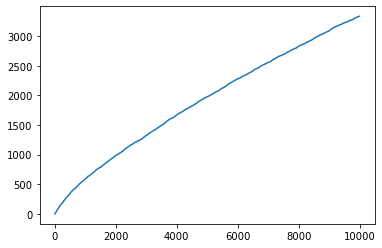

In [53]:
plt.plot(*np.array(ucb.R_log).T)

/opt/anaconda3/envs/cse541/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


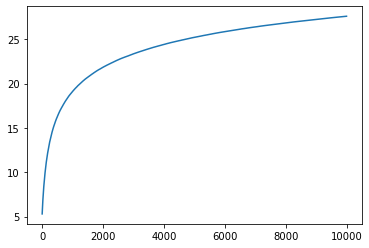

In [56]:
plt.plot(ucb.beta_log)

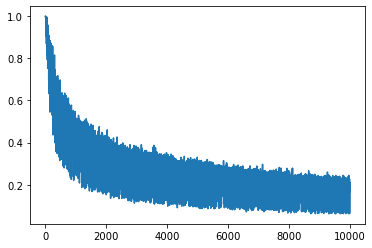

In [57]:
plt.plot(np.array(ucb.elip_log)[:,1])

In [58]:
beta = np.vstack(ucb.beta_log).reshape(-1)
elip = np.array(ucb.elip_log)[:,1].reshape(-1)

In [59]:
bound = np.sqrt(beta) * elip

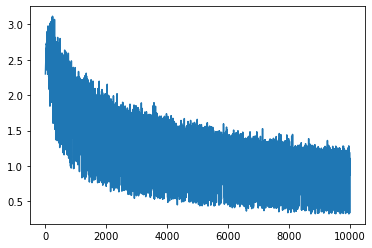

In [60]:
plt.plot(bound)